# DPS AI ENGINEER CHALLENGE

Imports

In [1]:
# Import Lib
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor

Data load and initial processing

In [2]:
# Load Data into a dataframe
data = pd.read_csv("E:/DPS Challenge/DataFile.csv")

In [3]:
# Selecting the first five important columns
data = data.iloc[:, :5]

#Renaming Columns for ease
data = data.rename( columns = { 
    'MONATSZAHL' : 'Category',
    'AUSPRAEGUNG': 'Accident_Type',
    'JAHR'       : 'Year',
    'MONAT'      : 'Month',
    'WERT'       : 'Value'
})

Extracting useful data

In [4]:
#Extracting Data till 2020 as mentioned in challenge for training 
#Data for 2021 will be used as testing data
Required_Data = data[data['Year'] < 2021]
Testing_Data = data[data['Year'] == 2021]


Visualization

In [5]:
# Select rows where 'Month' is 'Summe' 
summe_data = Required_Data[Required_Data['Month'] == 'Summe']

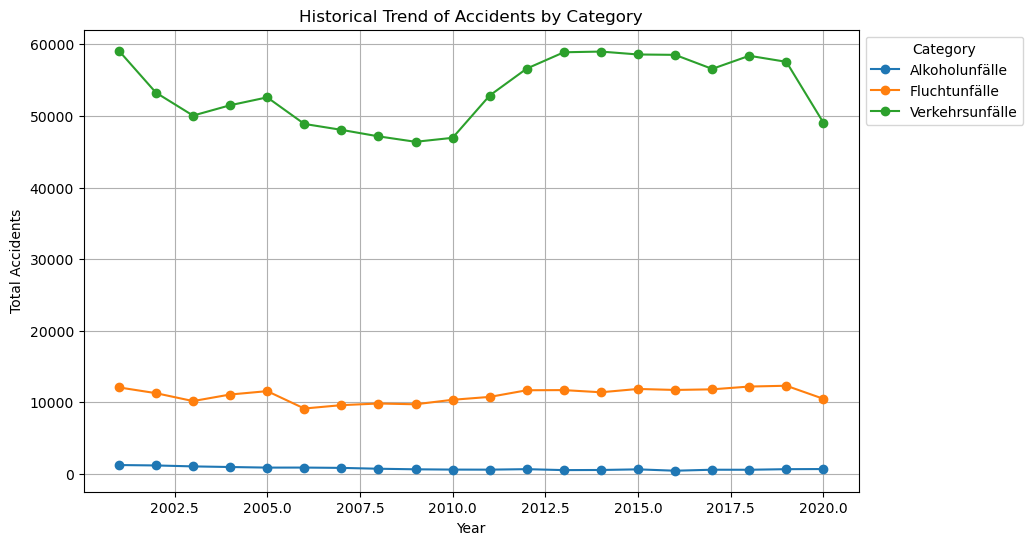

In [6]:
# Group the data by 'Year' and sum the 'Value' column to get the total accidents for each year
grouped_data = summe_data.groupby(['Year', 'Category'])['Value'].sum().reset_index()

# Pivot the data to have 'Year' as the index, 'Category' as columns, and 'Value' as the values
pivot_data = grouped_data.pivot(index='Year', columns='Category', values='Value')

# Plot the historical trend for each category
pivot_data.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Historical Trend of Accidents by Category')
plt.xlabel('Year')
plt.ylabel('Total Accidents')
plt.legend(title='Category', bbox_to_anchor=(1, 1))
plt.grid(True)

# Save the plot as an image file (e.g., PNG, JPEG, PDF)
plt.savefig('E:/DPS Challenge/Trend of accidents by category.png', bbox_inches='tight')

plt.show()

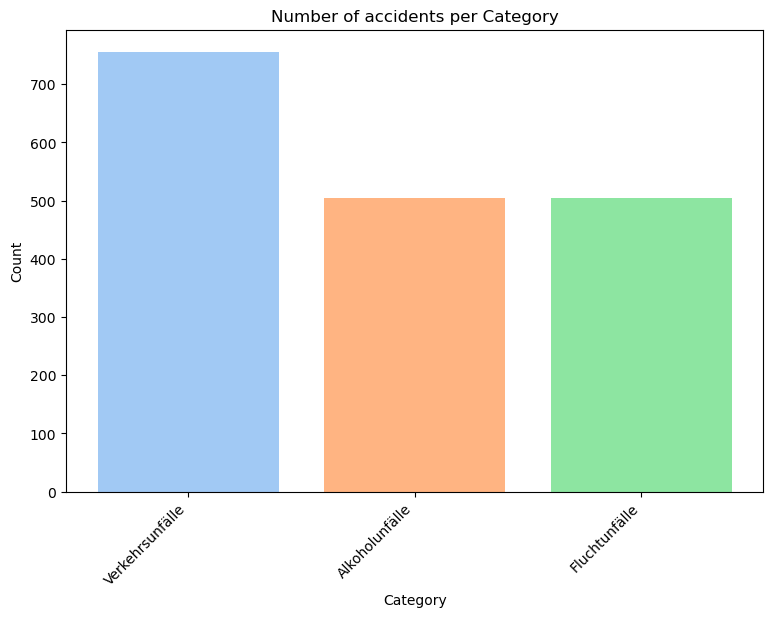

In [7]:
# Remove the 'Summe' from Month column 
data_pivot = Required_Data[Required_Data['Month'] != 'Summe']

# Plot Number of accidents per category
category_counts = data_pivot['Category'].value_counts()
colors = sns.color_palette('pastel', n_colors=len(category_counts))
plt.bar(category_counts.index, category_counts.values, color=colors)
plt.title('Number of accidents per Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.gcf().set_size_inches(9, 6)

# Save the plot as an image file (e.g., PNG, JPEG, PDF)
plt.savefig('E:/DPS Challenge/Number of accidents per category.png', bbox_inches='tight')

plt.show()


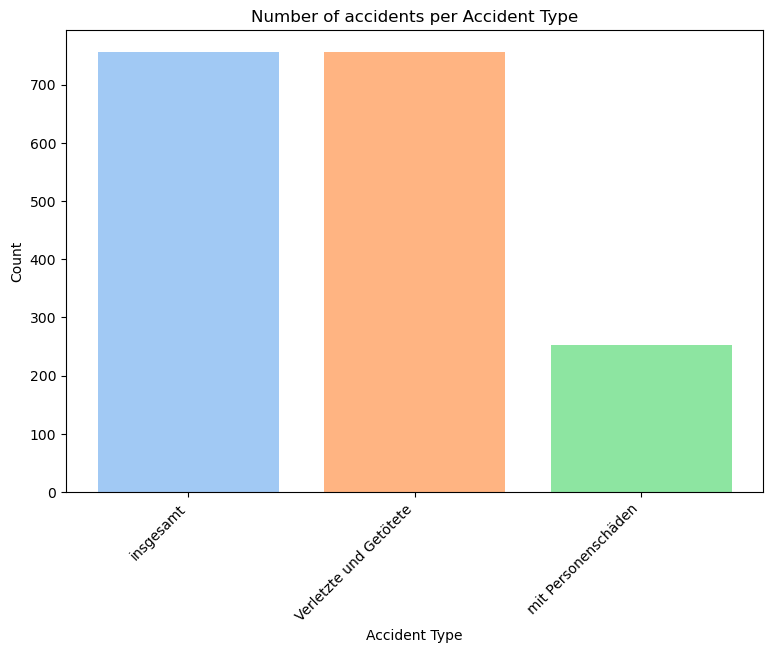

In [8]:
# Plot Number of accidents per Accident Type
accident_type_counts = data_pivot['Accident_Type'].value_counts()
colors = sns.color_palette('pastel', n_colors=len(category_counts))
plt.bar(accident_type_counts.index, accident_type_counts.values, color=colors)
plt.title('Number of accidents per Accident Type')
plt.xlabel('Accident Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.gcf().set_size_inches(9, 6)

# Save the plot as an image file (e.g., PNG, JPEG, PDF)
plt.savefig('E:/DPS Challenge/Number of accidents per accident type.png', bbox_inches='tight')

plt.show()


Preparing Data for Model

In [9]:
#Extracting required data for training
model_data=data_pivot[(data_pivot['Category'] == 'Alkoholunfälle') & (data_pivot['Accident_Type'] == 'insgesamt') & (data_pivot['Month'] != 'Summe')][['Year','Month','Value']]
model_data['Month'] = pd.to_datetime(model_data['Month'], format='%Y%m').dt.month

In [10]:
#Extracting required data for testing
Testing_Data = Testing_Data[(Testing_Data['Category'] == 'Alkoholunfälle') & (Testing_Data['Accident_Type'] == 'insgesamt') & (Testing_Data['Month'] != 'Summe')][['Year','Month','Value']]
Testing_Data['Month'] = pd.to_datetime(Testing_Data['Month'], format='%Y%m').dt.month

Model Training

In [11]:

# Extracting features and target variable
X = model_data[['Year', 'Month']]
y = model_data['Value']

X_test = Testing_Data[['Year', 'Month']]
y_test = Testing_Data['Value']

# Preprocessing: One-hot encode the 'Month' column
preprocessor = ColumnTransformer(
    transformers=[
        ('month_onehot', OneHotEncoder(), ['Month'])
    ],
    remainder='passthrough'
)

X_train_preprocessed = preprocessor.fit_transform(X)
X_test_preprocessed = preprocessor.transform(X_test)

# Initialize and train the linear regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_preprocessed, y)

# Make predictions on the test set
predictions = model.predict(X_test_preprocessed)



In [ ]:
# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')


Save Model and Transformer

In [13]:
with open('E:/DPS Challenge/dps_model_and_transformer.pkl', 'wb') as file:
    pickle.dump({
        'model': model,
        'transformer': preprocessor
    }, file)